# Project 5 - Vehicle Detection and Tracking

The goals / steps of this project are the following:

 - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
 - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
 - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
 - Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
 - Estimate a bounding box for vehicles detected.

## Load in Needed Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import sklearn
import skimage
from skimage.feature import hog

%matplotlib inline

## Perform and Define Feature Extraction Functions

### Load Test Images

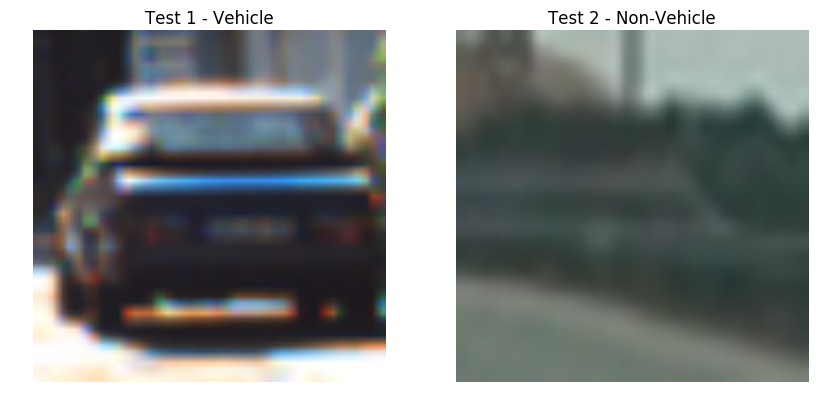

In [2]:
# Load in Test Images
test1 = mpimg.imread('training_data/test_v1.png')
test2 = mpimg.imread('training_data/test_n1.png')

# Plot Test Images for Vechicle and Non-Vehicle
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Test 1 - Vehicle')
plt.imshow(test1)

plt.subplot(1, 2, 2)
plt.imshow(test2)
plt.axis('off')
plt.title('Test 2 - Non-Vehicle')

### Perform Histogram of Oriented Gradients (HOG) Feature Extraction

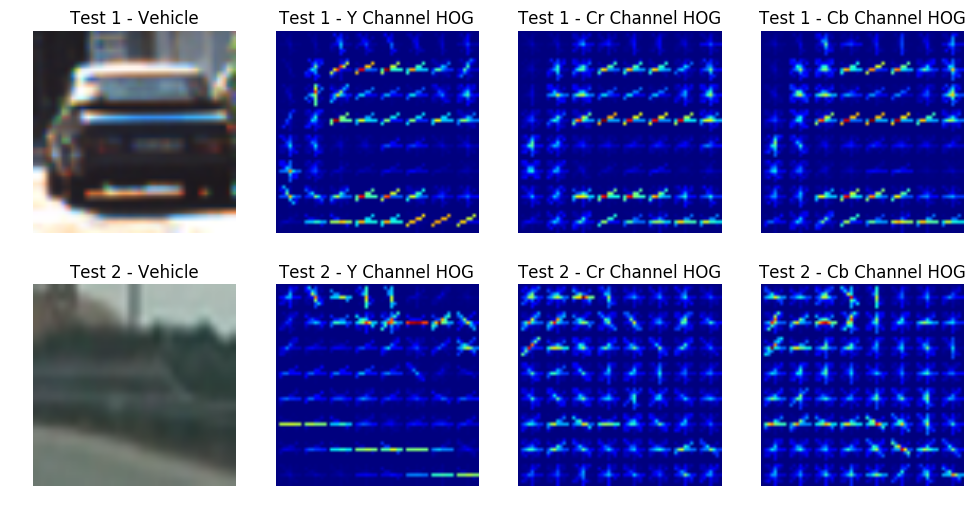

In [3]:
# Convert Image to YCrCb Color Space
test1_ycr = cv2.cvtColor(test1,cv2.COLOR_RGB2YCrCb)
test2_ycr = cv2.cvtColor(test2,cv2.COLOR_RGB2YCrCb)

# Extract YCrCb-Channels
test1_strip1 = test1_ycr[:,:,0]
test1_strip2 = test1_ycr[:,:,1]
test1_strip3 = test1_ycr[:,:,2]

test2_strip1 = test2_ycr[:,:,0]
test2_strip2 = test2_ycr[:,:,1]
test2_strip3 = test2_ycr[:,:,2]

# Extract HOG Features from Each Channel
fd1, test1_hog1 = hog(test1_strip1, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

fd1, test1_hog2 = hog(test1_strip2, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

fd1, test1_hog3 = hog(test1_strip3, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

fd1, test2_hog1 = hog(test2_strip1, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

fd1, test2_hog2 = hog(test2_strip2, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

fd1, test2_hog3 = hog(test2_strip3, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

# Show Features
plt.figure(figsize=(12,6))
plt.subplot(2, 4, 1)
plt.axis('off')
plt.title('Test 1 - Vehicle')
plt.imshow(test1)

plt.subplot(2, 4, 2)
plt.imshow(test1_hog1)
plt.axis('off')
plt.title('Test 1 - Y Channel HOG')

plt.subplot(2, 4, 3)
plt.axis('off')
plt.title('Test 1 - Cr Channel HOG')
plt.imshow(test1_hog2)

plt.subplot(2, 4, 4)
plt.imshow(test1_hog3)
plt.axis('off')
plt.title('Test 1 - Cb Channel HOG')

plt.subplot(2, 4, 5)
plt.axis('off')
plt.title('Test 2 - Vehicle')
plt.imshow(test2)

plt.subplot(2, 4, 6)
plt.imshow(test2_hog1)
plt.axis('off')
plt.title('Test 2 - Y Channel HOG')

plt.subplot(2, 4, 7)
plt.axis('off')
plt.title('Test 2 - Cr Channel HOG')
plt.imshow(test2_hog2)

plt.subplot(2, 4, 8)
plt.imshow(test2_hog3)
plt.axis('off')
plt.title('Test 2 - Cb Channel HOG')

### Create Functions for Feature Extraction

In [4]:
# Create Color Conversion Function - From Lessons
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Create HOG Feature Extraction Function
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        return features

# Create a Spatial Feature Extraction
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
# Create a Histogram Feature Extraaction Function
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Spatial Feature Extraction

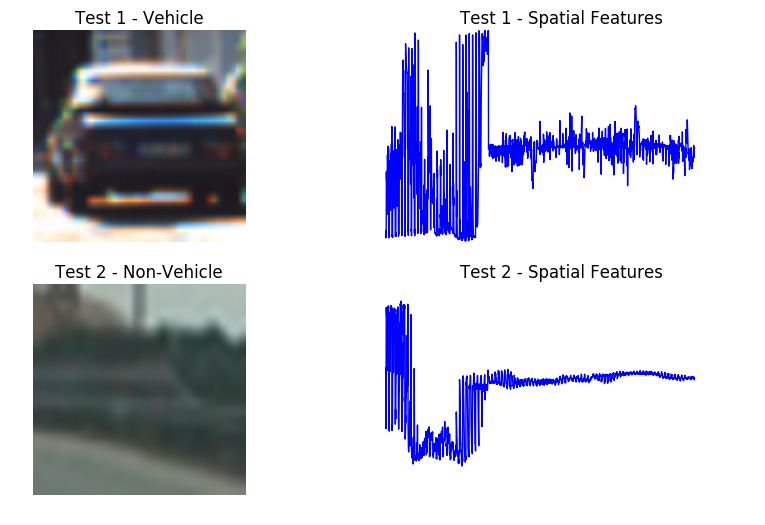

In [5]:
# Extract Spatial Features
spatial_feat_1 = bin_spatial(test1_ycr)
spatial_feat_2 = bin_spatial(test2_ycr)

# Show Features
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Test 1 - Vehicle')
plt.imshow(test1)

plt.subplot(2, 2, 2)
plt.plot(spatial_feat_1)
plt.axis('off')
plt.title('Test 1 - Spatial Features')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title('Test 2 - Non-Vehicle')
plt.imshow(test2)

plt.subplot(2, 2, 4)
plt.plot(spatial_feat_2)
plt.axis('off')
plt.title('Test 2 - Spatial Features')

### Histogram Color Feature Extraction

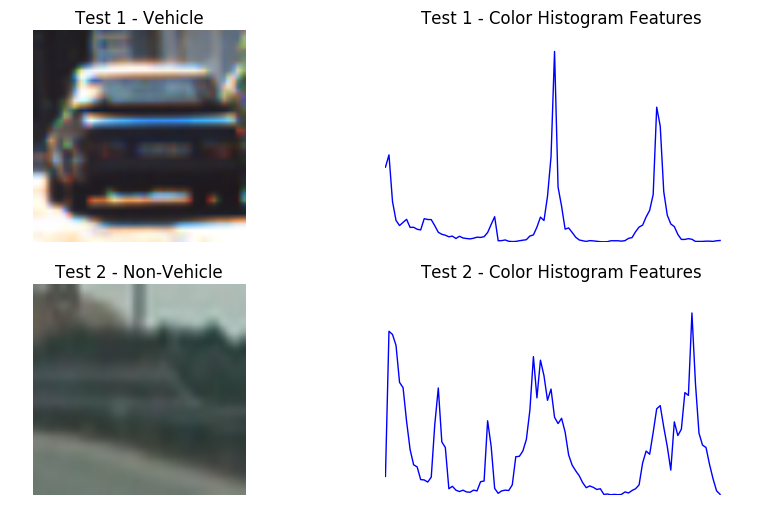

In [6]:
# Extract Spatial Features
hist_feat_1 = color_hist(test1_ycr)
hist_feat_2 = color_hist(test2_ycr)

# Show Features
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Test 1 - Vehicle')
plt.imshow(test1)

plt.subplot(2, 2, 2)
plt.plot(hist_feat_1)
plt.axis('off')
plt.title('Test 1 - Color Histogram Features')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title('Test 2 - Non-Vehicle')
plt.imshow(test2)

plt.subplot(2, 2, 4)
plt.plot(hist_feat_2)
plt.axis('off')
plt.title('Test 2 - Color Histogram Features')

## Create and Train a SVC Classifier

### Load images from File and Create Feature Lists for Classification

In [7]:
# Load Test Images
test_images_v = glob.glob('./training_data/vehicles/*.png')
test_images_n = glob.glob('./training_data/non-vehicles/*.png')

# Create Label Array
labels_v = np.ones(len(test_images_v), dtype=np.int)
labels_n = np.zeros(len(test_images_n), dtype=np.int)

# Create Empty Arrays for Extracted Features
train_v = []
train_n = []

# Define HOG Parameters
pix_per_cell = 8
cell_per_block = 2
orient = 9

# Read Images and Perform Feature Extraction for Vehicles
for img in test_images_v:
    
    # Read .png Images (Note: No need to scale features)
    temp = mpimg.imread(img)
    
    # Convert Image to YCrCb Colorspace
    temp_ycr = convert_color(temp, conv='RGB2YCrCb')

    # Extract Each Color Channel
    temp_ch1 = temp_ycr[:,:,0]
    temp_ch2 = temp_ycr[:,:,1]
    temp_ch3 = temp_ycr[:,:,2]

    # Get HOG Features for Each Channel
    temp_hog1 = get_hog_features(temp_ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    temp_hog2 = get_hog_features(temp_ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    temp_hog3 = get_hog_features(temp_ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Stack HOG Feature Array
    hog_features = np.hstack((temp_hog1.ravel(), temp_hog2.ravel(), temp_hog3.ravel()))
    
    # Perform Spatial Feature Extraction
    spatial_features = bin_spatial(temp_ycr)
    
    # Perform Histogram Feature Extraction
    hist_features = color_hist(temp_ycr)

    # Stack All Feature Arrays
    test_features = np.hstack((spatial_features, hist_features, hog_features))
    
    # Append Arrays to train_v list
    train_v.append(test_features)

# Print a Completed Statement
print('Finished loading vehicle images')

# Read Images and Perform Feature Extraction for non-Vehicles
for img in test_images_n:
    
    # Read .png Images (Note: No need to scale features)
    temp = mpimg.imread(img)

    # Convert Image to YCrCb Colorspace
    temp_ycr = convert_color(temp, conv='RGB2YCrCb')

    # Extract Each Color Channel
    temp_ch1 = temp_ycr[:,:,0]
    temp_ch2 = temp_ycr[:,:,1]
    temp_ch3 = temp_ycr[:,:,2]

    # Get HOG Features for Each Channel
    temp_hog1 = get_hog_features(temp_ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    temp_hog2 = get_hog_features(temp_ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    temp_hog3 = get_hog_features(temp_ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Stack HOG Feature Array
    hog_features = np.hstack((temp_hog1.ravel(), temp_hog2.ravel(), temp_hog3.ravel()))
    
    # Perform Spatial Feature Extraction
    spatial_features = bin_spatial(temp_ycr)
    
    # Perform Histogram Feature Extraction
    hist_features = color_hist(temp_ycr)

    # Stack All Feature Arrays
    test_features = np.hstack((spatial_features, hist_features, hog_features))
    
    # Append Arrays to train_n list
    train_n.append(test_features)

# Print a Completed Statement
print('Finished loading non-vehicle images.')
print()

# Print Statements for Total Samples Collected
print('Number of vehicle samples: ',len(train_v), 'with ', labels_v.shape, 'labels.')
print('Number of non-vehicle samples: ',len(train_n), 'with ', labels_n.shape, 'labels.')

Finished loading vehicle images
Finished loading non-vehicle images.

Number of vehicle samples:  6941 with  (6941,) labels.
Number of non-vehicle samples:  8968 with  (8968,) labels.


### Train a SVC Classifier on the Extracted Features

In [8]:
# Load Classifier Libraries
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Stact Vehicle and Non-vehicle Arrays
x_train = np.vstack((train_v, train_n)).astype(np.float64)
y_train = np.hstack((labels_v, labels_n))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(x_train)

# Apply the scaler to X
scaled_X = X_scaler.transform(x_train)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y_train, test_size=0.2, random_state=rand_state)

# Call SVC Classifier
svc = LinearSVC()

# Fit Classifier to the Training Data
svc.fit(X_train, y_train)

# Test the Classifier Against Test Data
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Test Accuracy of SVC =  0.9953


### Wrap all Functions into a Find Cars Function

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    # Create a Copy Image to Draw on
    draw_img = np.copy(img)
    
    # Test Images are in .jpg format so scaling is required.
    img = img.astype(np.float32)/255
    
    # Constrain the Searchable Image Area to ystart and ystop
    img_tosearch = img[ystart:ystop,:,:]
    
    # Convert to YCrCb Color Space
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # If Scaling is Applied, Reshape the Image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Extract Each Color Channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define Window Step Blocks 
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Search Subspaces of the image for Cars
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # Find Current Step
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Define Stepping Area
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # Draw Bounding Box if Prediction is True
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

### Test the Classifier on Images

In [ ]:
# Load Test Images
test_images = glob.glob('./training_data/seq/*.jpg')

# Define Search Window Parameters
ystart = 400
ystop = 656
scale = 1.5

# Define HOG Parameters
pix_per_cell = 8
cell_per_block = 2
orient = 9
    
# Cycle Each Test Image
for img in test_images:
    
    # Read Image
    temp = mpimg.imread(img)

    # Run Image through Find Cars Function
    out_img = find_cars(temp, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    # Plot Test Images
    plt.figure()
    plt.imshow(out_img)

## Create Method to Filter False Positives

### Update Find Cars Function to Output Boxes

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_heat(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    # Create a Copy Image to Draw on
    draw_img = np.copy(img)
    
    # Test Images are in .jpg format so scaling is required.
    img = img.astype(np.float32)/255
    
    # Constrain the Searchable Image Area to ystart and ystop
    img_tosearch = img[ystart:ystop,:,:]
    
    # Convert to YCrCb Color Space
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # Create Empty Array for Box Lists
    box_list = []
    
    # If Scaling is Applied, Reshape the Image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Extract Each Color Channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define Window Step Blocks 
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Search Subspaces of the image for Cars
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # Find Current Step
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Define Stepping Area
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # Draw Bounding Box if Prediction is True
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, box_list

### Create Function to Create a Heatmap

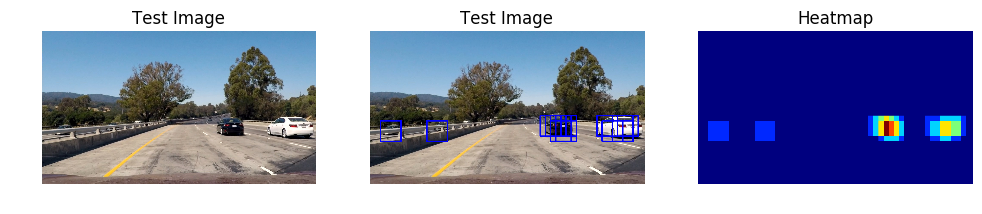

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Load Test Image
image = mpimg.imread('training_data/test1.jpg')

out_img, box_list = find_cars_heat(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

# Create an Empty Map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add Heat
heatmap = add_heat(heat, box_list)

# Plot Test Images
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Test Image')
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Test Image')
plt.imshow(out_img)

plt.subplot(1, 3, 3)
plt.imshow(heatmap)
plt.axis('off')
plt.title('Heatmap')

### Create a Function to Threshold the Image

2 cars found


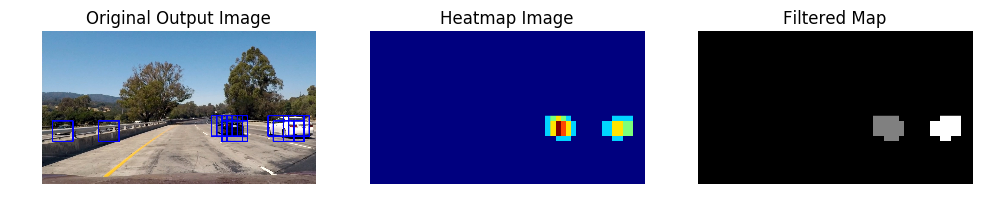

In [13]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)
print(labels[1], 'cars found')

# Plot Image Results
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original Output Image')
plt.imshow(out_img)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Heatmap Image')
plt.imshow(heatmap)

plt.subplot(1, 3, 3)
plt.imshow(labels[0], cmap='gray')
plt.axis('off')
plt.title('Filtered Map')

### Create Function to Redraw Boxes

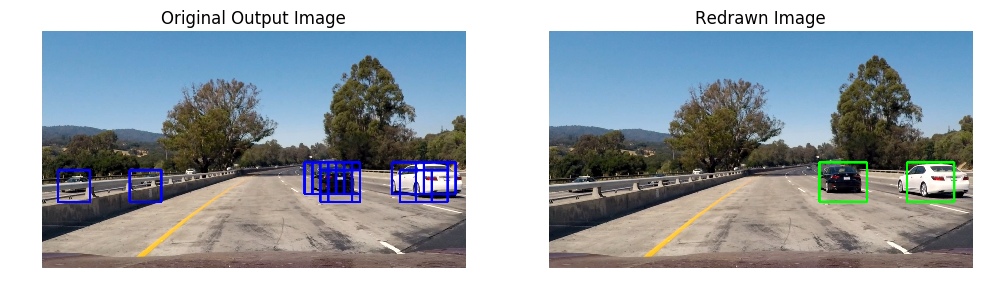

In [14]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

new_img = draw_labeled_bboxes(image,labels)

# Plot Image Results
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Output Image')
plt.imshow(out_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Redrawn Image')
plt.imshow(new_img)

## Create Video Pipeline

### Define a Class to Store Variables

In [15]:
# Create a Class to Store Information between Video Frames
class heat():
    def __init__(self):
        
        self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        self.heatmap_list = []

### Redefine Find Cars Function for Videos

In [16]:
# Define a Function that Finds Cars Quickly
def find_cars_fast(img, svc, X_scaler, scale, ystart, ystop, orient=9, pix_per_cell=8, cell_per_block=2):
    
    scaled_img = img.astype(np.float32)/255
    
    img_tosearch = scaled_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Create Array for boxes
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
        
        current_heatmap = add_heat(np.zeros_like(img[:,:,0]).astype(np.float), box_list)
        
    return current_heatmap

### Create a Video Processing Pipeline

In [17]:
def process_video_fast(img):

    # Generate Heatmaps for Multiple Image Viewing Scales
    heatmap1 = find_cars_fast(img, svc, X_scaler, scale=.75, ystart=400, ystop=528)
    heatmap2 = find_cars_fast(img, svc, X_scaler, scale=1.5, ystart=400, ystop=656)
    heatmap3 = find_cars_fast(img, svc, X_scaler, scale=2.0, ystart=350, ystop=656)

    # Combine Heatmaps
    current_heatmap = heatmap1 + +heatmap2*2 + heatmap3*4
    
    # Add current heatmap to the sum of heatmaps
    heat.heatmap = (heat.heatmap + current_heatmap)
    
    # Clear Left Side of the Image (Filter Other Lane)
    heat.heatmap[:,:600] = 0

    # Append Current Map to List
    heat.heatmap_list.append(current_heatmap)

    # Remove heatmap that is older than 10 frames
    if len(heat.heatmap_list) > 10:
        remove_heat = heat.heatmap_list.pop(0)
        heat.heatmap -= remove_heat

    # Apply thresholding to the heatmap sum
    labelmap = apply_threshold(heat.heatmap, 4)
    
    # Generate labels for the blob images
    labels = label(labelmap)        
    
    # Draw a new Image with bounding boxes
    draw_img = draw_labeled_bboxes(img, labels)

    return draw_img

### Test Pipeline on a Series of Images

In [ ]:
# Load Test Images
test_images = glob.glob('./training_data/seq/*.jpg')

# Initialize a Heat Classifier
heat = heat()

# Cycle Through Test Images
for img in test_images:
    temp = mpimg.imread(img)

    out_img = process_video_fast(temp)
    
    plt.figure()
    plt.imshow(out_img)

## Run Pipeline on a Video

### Reinitialize the Heat Class

In [19]:
# Delete Heatmap and List from Previous Run
heat.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heat.heatmap_list = []

### Load Video Libraries

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Run Pipeline on a Test Video

In [21]:
project_output_fast = 'test_video_fast.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip_fast = clip1.fl_image(process_video_fast) #NOTE: this function expects color images!!
%time project_clip_fast.write_videofile(project_output_fast, audio=False)

[MoviePy] >>>> Building video test_video_fast.mp4
[MoviePy] Writing video test_video_fast.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:19<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_fast.mp4 

Wall time: 1min 20s


### Reinitialize the Heat Class

In [22]:
# Delete Heatmap and List from Previous Run
heat.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heat.heatmap_list = []

### Run on Project Video

In [23]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_video_fast) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [44:07<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 44min 8s
